In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter(action="ignore",category=FutureWarning)

首先读取数据，选取科创板开板首日上市的25支股票。截取2019年7月23日到2021年7月31日交易数据作为训练数据，2021年8月1日到2022年4月15日交易数据作为测试数据

In [2]:
'''读取数据'''
data=pd.read_csv('STARDATA.csv').set_index('date')
data.index=pd.to_datetime(data.index.astype(str),format='%Y%m%d')

'''数据预处理，将首日的0去掉，将0替换成nan'''
data=data.replace(0,np.nan)

'''读股票信息'''
info=pd.read_csv('Stockinfo.csv')
info['code']=info['code'].astype(str)

In [3]:
train_data=data[data.index<='2021-07-31']

In [4]:
'''为获得最长的数据范围，从开板时的初始25支股票中选择标的范围'''
og_stock=train_data.iloc[0].dropna().index

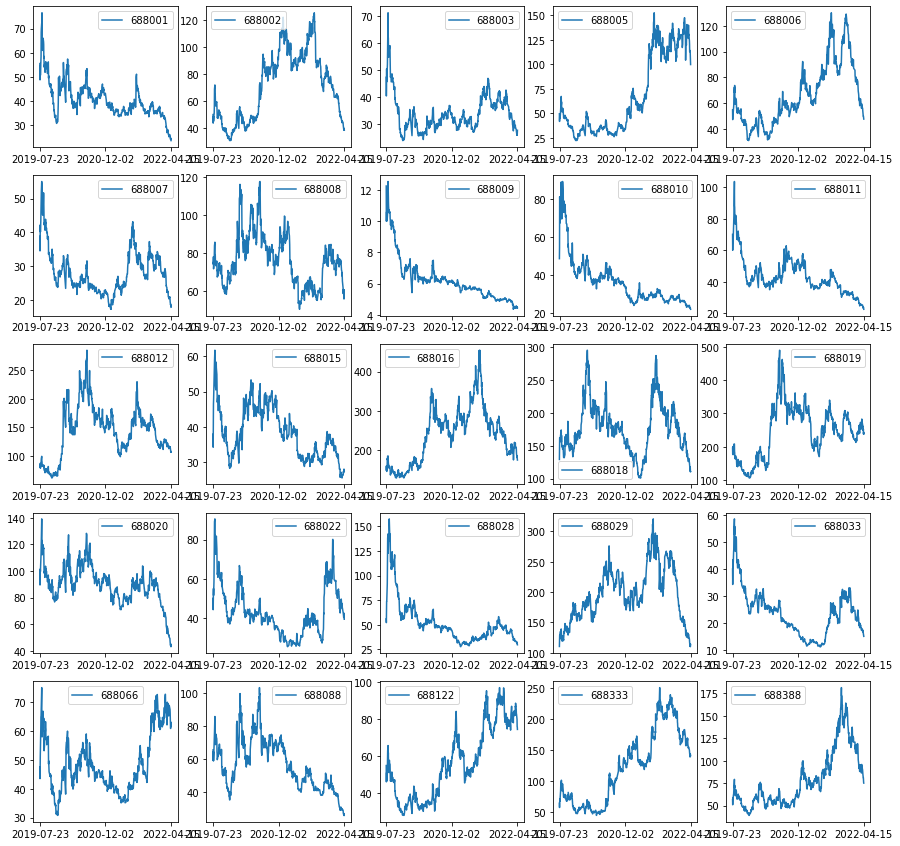

In [5]:
'''作图'''
k=1
plt.figure(1,figsize=(15,15))

for i in og_stock:
    fig=plt.subplot(5,5,k)
    k+=1
    plot1=plt.plot(data[i])
    plt.legend([i])
    plt.xticks(data[i].index[(range(1,len(data[i]),round(len(data[i])/2)-1))])
    # if k==401:
    #     break
# plt.savefig('STARprice.png') 
plt.show()

选择688001，688002，688005,688333,688029五只股票作为投资组合标的

In [6]:
stock_list=['688001','688002','688005','688333','688029','688019']
info[info['code'].isin(stock_list) ]

,code,name,industry,cmv,mv,pe,csc
62,688005,容百科技,材料,2.914487e+10,4.734414e+10,51.967,275810300
63,688019,安集科技,材料,7.603742e+09,1.319870e+10,105.519,30660252
249,688333,铂力特,工业,6.658262e+09,1.164929e+10,-218.538,46177001
260,688001,华兴源创,信息技术,1.203051e+09,1.048816e+10,33.405,50400105
351,688029,南微医学,医疗保健,5.308550e+09,1.599082e+10,61.324,44400720
387,688002,睿创微纳,信息技术,1.047639e+10,1.817101e+10,39.401,257152320


# 利用policy gradient实现简单的单股票交易

强化学习的训练过程在代理和环境的交互之中进行，首先要定义代理和环境。  
## 强化学习的组件准备   
**代理**   
agent应该能够模拟一个投资者对某股票的交易行为，并有自己的账户记录当前的持仓、头寸，并有自己的账本记录整个交易过程每一步的决策和盈亏等信息。

In [802]:
class agent():
    '''
    属性：
    state ：记录当前投资者的各项关键信息，包括头寸、持仓、以及账户余额等信息
    action：记录代理的上一个交易动作
    memory：记录交易历史，以及每个时点的余额、持仓信息
    action_sequence: 记录所有交易动作
    logits：记录所有模型的输出
    
    '''
    '''初始化agent，输入起始资金和交易股票列表'''
    def __init__(self,initial_capital,stock_list):

        self.initial_capital=initial_capital
        self.state=dict(money=initial_capital,position=0,wealth=initial_capital)
        self.stock_list=stock_list
        self.action=[]
        self.memory=pd.DataFrame(columns=['datetag','money','position','wealth','action','log_return','reward'])
        self.action_sequence=[]
        self.logits=[]

    '''讲代理的状态信息归零'''
    def init_state(self):
        self.state=dict(money=self.initial_capital,position=0,wealth=self.initial_capital)

    '''根据模型的输出，计算各交易行为的概率，并随机采样出交易行为'''
    def take_action(self,logits):
        '''
        action [0]: sell
        action [1]: buy
        action [2]: hold
        :param observation:
        :return:
        '''
        probs= tf.nn.softmax(logits)
        self.action = tf.random.categorical(probs, num_samples=1)
        self.action_sequence.append(self.action)
        self.logits.append(logits)
        return self.action

    '''更新agent的state'''
    def update_state(self,d_state):
        self.state['money'] += d_state['money']
        self.state['position'] += d_state['position']
        self.state['wealth'] = d_state['wealth']
        self.state['action'] = d_state['action']

    '''插入最新的交易信息'''
    def update_memory(self,datetag):
        self.memory=self.memory.append(dict(datetag=datetag,money=self.state['money'],position=self.state['position'],
                                wealth=self.state['wealth'],action=self.state['action'],log_return=0,reward=0),ignore_index=True)

    '''清空代理的记忆'''
    def clear_memory(self):
        self.memory=self.memory.drop(index=self.memory.index)
        self.action_sequence=[]
        self.logits=[]

        
    '''以下方法均为计算reward的方法，为测试不同reward对模型训练效果的影响，设计了不同的几种reward计算方法'''
    def calculate_reward(self,gamma=0.9):
        self.memory['log_return']=np.log(self.memory['wealth'].astype(float)) - np.log(self.memory['wealth'].astype(float)).shift(1)
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            R = R * gamma + t
            discounted_rewards[-i - 1] = R
        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        
        
    def calculate_second_reward(self,gamma=0.9):
        self.memory['log_return']=self.memory['wealth'].astype(float) - self.memory['wealth'].astype(float).shift(1)
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            R = R * gamma + t
            discounted_rewards[-i - 1] = R
        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        
    
    def calculate_third_reward(self,gamma=0.9):
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['wealth'])):
            q= 100 if t>10000 else -200
            R = R * gamma + q
            discounted_rewards[-i -1] = R
        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        
    
    def calculate_fourth_reward(self,gamma=0.9):
        self.memory['reward'] = (self.state['wealth']/self.initial_capital)-1
        self.memory['reward']=self.memory['reward'].shift(-1)
        
    def calculate_fifth_reward(self,gamma=0.9):
        self.memory['log_return']=self.memory['wealth'].astype(float) - self.memory['wealth'].astype(float).shift(1)
        
        self.memory.loc[self.memory['action']==0,'log_return']=0
        
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            q= 1 if t>0 else -1
            if i==0:
                if self.state['wealth']>self.initial_capital:
            # discounted_rewards[-1]=discounted_rewards[-1]+(self.state['wealth']-self.initial_capital)
                    q=q+100
                elif self.state['wealth'] == self.initial_capital:
                    q=q-50
                else:
                    q=q-100
                
            R = R * gamma + q
            discounted_rewards[-i - 1] = R

        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        
    def calculate_sixth_reward(self,gamma=0.9):
        
        self.memory['log_return']=self.memory['wealth'].astype(float) - self.memory['wealth'].astype(float).shift(1)
        
        # self.memory.loc[self.memory['action']==0,'log_return']=0  
        
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            q= t
            if i==0:
                q+=self.state['wealth']-self.initial_capital
                # if self.state['wealth']>self.initial_capital:
                #     q=q+10000
                # elif self.state['wealth'] == self.initial_capital:
                #     q=q-5000
                # else:
                #     q=q-10000
                
            R = R * gamma + q
            discounted_rewards[-i - 1] = R

        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        

**环境**   
模拟市场交易环境，由于本例只研究对单只股票的交易，只需要针对该股票的交易行为做出反馈即可。

In [ ]:
class market_env():
    '''根据股票价格数据初始化环境'''
    def __init__(self,data,stock):
        self.data=data[stock]
        
    '''根据agent的动作，返回其动作的影响；action取值 [1]为买入 [2]为无交易 [0]为卖出'''
    def reveive_action(self,action,state,datetag):
        price = self.data[datetag]
        # print('action:',action)
        if action==[1]:
            '''buy'''
            if state['money']>=price:
                volume = np.floor(state['money'] / price)
                d_money = -(volume * price)
                d_position = volume
            else:
                d_money = 0
                d_position = 0
        if action==[0]:
            '''sell'''
            earn=state['position']*price
            d_money=earn
            d_position=-state['position']
        if action==[2]:
            d_money=0
            d_position=0
        new_wealth=state['money']+state['position']*price
        return dict(money=d_money,position=d_position,wealth=new_wealth,action=action)

**交易模型**

In [1180]:
'''交易模型'''
def trade_bot(num_units,num_actions,input_num):
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=num_units, 
                                                              activation='relu',
                                                              input_shape=(input_num,)),
                                        tf.keras.layers.Dense(units=num_actions)])
    return model

**损失函数**

In [203]:
'''compute loss'''
def compute_loss(logits, actions, rewards_aaa): 
    neg_logprob=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
    loss = tf.reduce_mean(neg_logprob*rewards_aaa)
    return loss

## 准备训练数据,开始训练过程  
1. 将最近六日数据作为X输入
2. 再尝试简单的特征工程，如将最近六日价格的均值、最近三日价格的均值作为新的特征输入模型

DatetimeIndex(['2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-29', '2019-07-30', '2019-07-31',
               '2019-08-01', '2019-08-02',
               ...
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-26', '2021-07-27', '2021-07-28',
               '2021-07-29', '2021-07-30'],
              dtype='datetime64[ns]', name='date', length=494, freq=None) -0.03066271018793265


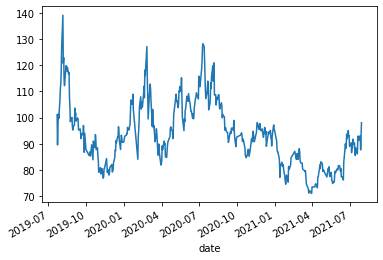

In [11]:
'''了解该股票训练期间价格走向'''
one_stock_data.plot()
print(one_stock_data.index,(one_stock_data[-1]/one_stock_data[0])-1)

准备开始训练过程，首先对代理、环境、模型进行初始化，并以六个交易日价格数据为滑动窗口，重构价格数据，整理成训练数据集x。   
数据x的整理有两种思路，首先是计算出每日较上一日的对数收益率并以此作为模型输入；第二种是直接对训练阶段的该股票价格数据进行标准化。这里为训练方便，采用第二种方法。

In [1188]:
'''test train code'''
T=6
stock='688008'
one_stock_data=train_data[stock]

'''尝试将x转化为log收益率，将收益率作为模型输入'''
# log_return=np.log(one_stock_data) - np.log(one_stock_data).shift(1)
# log_return=log_return.fillna(0)
# log_return=log_return*10
# x=np.array([log_return[i-T:i] for i in range(T,len(log_return))])   

'''直接利用价格作为模型输入'''
x=np.array([one_stock_data[i-T:i] for i in range(T,len(one_stock_data))])
'''尝试将x标准化'''
x=(x-np.mean(x))/np.std(x)
trade_model=trade_bot(128,3,input_num=(T+2))
trader1=agent(initial_capital=10000,stock_list=[stock])
mrk1=market_env(train_data,stock)

~~遇到的问题：仅用若干天价格输入，网络学习不到任何有用的信息。训练结果不收敛。   
进一步测试的内容：~~   
1. 略微增加网络层数
2. 在输入中添加特征
3. 更重要的问题是，我衡量的标准是最终wealth的积累，但这个标准不是reward和loss的标准，所以导致了这些差异。   
~~4. 还有一个想法：是不是可以搜索出那个最优的决策模型~~

In [1191]:
'''训练过程，并记录训练过程中出现的最佳模型'''
episode=50
learning_rate = 1e-7
optimizer = tf.keras.optimizers.Adam(learning_rate)
record=[]
loss_history=[]
milestone=0

# former_layer_weight=trade_model.get_weights()

for k in range(episode):
    '''初始化模型state 和 起始资金'''
    trader1.init_state()
    trader1.clear_memory()
    obs_set=np.empty((0,T+2),float)
      
    logits = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    actions = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    
    with tf.GradientTape() as tape: 
        '''根据当前模型预测交易行为0卖，1买，2不变'''
        for i,j in zip(range(len(mrk1.data.index[T-1:-2])),mrk1.data.index[T-1:-2]):
  
            '''这里的observation只有前T日的价格，但模型不收敛，考虑加特征维度:将T日平均，和T/2日平均加入输入'''
            observation=np.append(x[i],[np.mean(x[i]),np.mean(x[i][-round(T/2)::])])
            observation=tf.expand_dims(observation,axis=0)
            obs_set=np.vstack((obs_set,observation))
        
            '''将observation输入模型'''
            logit=trade_model(observation)
           
            logits = logits.write(i, tf.squeeze(logit))
            action=trader1.take_action(logit)
            actions=actions.write(i, tf.squeeze(action))
            d_state=mrk1.reveive_action(action,trader1.state,j)
            trader1.update_state(d_state)
            trader1.update_memory(j)
  
        record.append(trader1.state['wealth'])
    
        '''计算reward：gamma=0.9 效果不好 '''
        trader1.calculate_second_reward(gamma=0.5)
    
        '''记录最佳模型'''
        if trader1.state['wealth']>milestone:
            best_model=trade_model
            best_memory=trader1.memory
            milestone=trader1.state['wealth']
    
    
        reward_sdz=(trader1.memory['reward']-np.mean(trader1.memory['reward']))/(np.std(trader1.memory['reward'])+0.00001)
    
        reward_sdz=tf.convert_to_tensor(reward_sdz.fillna(0),dtype=tf.float32)
    
        '''模型参数更新'''
        actions=actions.stack()
        logits=logits.stack()
        
        loss=compute_loss(logits,actions,reward_sdz)
        # print('loss',loss)
        
    loss_history.append(loss)
    grads=tape.gradient(loss,trade_model.trainable_variables)
    # print('grads',grads)
    optimizer.apply_gradients(zip(grads, trade_model.trainable_variables))

    print('epoch#',k,'loss:',np.mean(loss),' wealth:',trader1.state['wealth'])
    # print('trainable variables:',trader1.model.trainable_variables)
    # print('grads: ',grads)
    
    '''查看权值更新情况'''
    # first_layer_weight=trader1.model.get_weights()
    # weights_diff=np.array(first_layer_weight)-np.array(former_layer_weight)
    # former_layer_weight=first_layer_weight
    # print('weights_diff: ',weights_diff)


epoch# 0 loss: -0.010977052  wealth: 15346.909999999994
epoch# 1 loss: -0.046901982  wealth: 13042.19
epoch# 2 loss: -0.049622018  wealth: 13187.260000000004
epoch# 3 loss: -0.024023306  wealth: 6970.629999999998
epoch# 4 loss: -0.04771937  wealth: 19457.74
epoch# 5 loss: -0.016179388  wealth: 14438.08
epoch# 6 loss: -0.012727068  wealth: 9186.059999999972
epoch# 7 loss: -0.028307255  wealth: 7069.470000000009
epoch# 8 loss: -0.021503374  wealth: 7722.279999999994
epoch# 9 loss: -0.038247082  wealth: 7393.0600000000095
epoch# 10 loss: -0.012583048  wealth: 15749.829999999984
epoch# 11 loss: -0.052048407  wealth: 7510.549999999995
epoch# 12 loss: -0.0034563644  wealth: 13284.51999999999
epoch# 13 loss: -0.0173358  wealth: 7612.809999999997
epoch# 14 loss: -0.002369848  wealth: 12527.319999999992
epoch# 15 loss: -0.014669464  wealth: 9842.600000000008
epoch# 16 loss: -0.016584273  wealth: 6083.009999999994
epoch# 17 loss: -0.032325853  wealth: 11050.71
epoch# 18 loss: -0.016956685  wealt

In [ ]:
'''探索过程在tape外'''
'''训练过程，并记录训练过程中出现的最佳模型'''
episode=500
learning_rate = 1e-7
optimizer = tf.keras.optimizers.Adam(learning_rate)
record=[]
loss=[]
milestone=0

former_layer_weight=trade_model.get_weights()

for k in range(episode):
    '''初始化模型state 和 起始资金'''
    trader1.init_state()
    trader1.clear_memory()
    obs_set=np.empty((0,T+2),float)
    '''根据当前模型预测交易行为0卖，1买，2不变'''
    for i,j in zip(range(len(mrk1.data.index[T-1:-2])),mrk1.data.index[T-1:-2]):
        # observation=np.expand_dims(x[i],axis=0)
        '''这里的observation只有前T日的价格，但模型不收敛，考虑加特征维度:将T日平均，和T/2日平均加入输入'''
        observation=np.append(x[i],[np.mean(x[i]),np.mean(x[i][-round(T/2)::])])
        observation=np.expand_dims(observation,axis=0)
        obs_set=np.vstack((obs_set,observation))
        
        '''将observation输入模型'''
        logits=trade_model(observation)
        action=trader1.take_action(logits)
        d_state=mrk1.reveive_action(trader1.action,trader1.state,j)
        # print(d_state)
        trader1.update_state(d_state)
        trader1.update_memory(j)
  
    record.append(trader1.state['wealth'])
    
    '''计算reward：gamma=0.9 效果不好 '''
    trader1.calculate_second_reward(gamma=0.5)
    
    '''记录最佳模型'''
    if trader1.state['wealth']>milestone:
        best_model=trade_model
        best_memory=trader1.memory
        milestone=trader1.state['wealth']
    
    
    reward_sdz=(trader1.memory['reward']-np.mean(trader1.memory['reward']))/(np.std(trader1.memory['reward'])+0.00001)
    # reward_sdz=(trader1.memory['reward'])/np.std(trader1.memory['reward'])
    # reward_sdz=(trader1.memory['reward'])
    
    reward_sdz=reward_sdz.fillna(0)
    vanila_reward=trader1.memory['reward']
    vanila_reward=vanila_reward.fillna(0)
    # print('reward:',reward_sdz)
    
    # print(np.shape(obs_set))
    # print(obs_set)
    
    '''模型参数更新'''
    actions=np.array(np.squeeze(np.squeeze(trader1.action_sequence,axis=1),axis=1))
    
    with tf.GradientTape() as tape:        
        logits=trade_model(obs_set)
        loss=compute_loss(logits,actions,reward_sdz)
        
    grads=tape.gradient(loss,trade_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, trade_model.trainable_variables))

    print('epoch#',k,'loss:',np.mean(loss),' wealth:',trader1.state['wealth'])
    # print('trainable variables:',trader1.model.trainable_variables)
    # print('grads: ',grads)
    
    '''查看权值更新情况'''
    # first_layer_weight=trader1.model.get_weights()
    # weights_diff=np.array(first_layer_weight)-np.array(former_layer_weight)
    # former_layer_weight=first_layer_weight
    # print('weights_diff: ',weights_diff)

~~训练问题是：~~   
~~1. 在采取行动时的随机采样波动性太强了，导致模型系数相同时，相同输入的结果也完全不同。~~   
~2. 神经网络模型对输入不敏感，对于不同的输入，输出总是同一种action的probs最高，差异性完全由随机采样产生。~

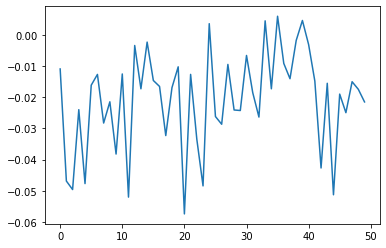

In [1192]:
plt.plot(loss_history)

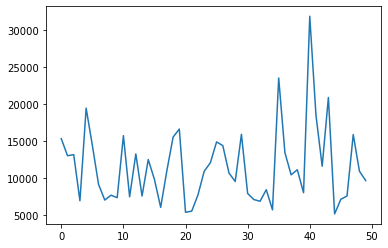

In [1193]:
plt.plot(record)

31843.71


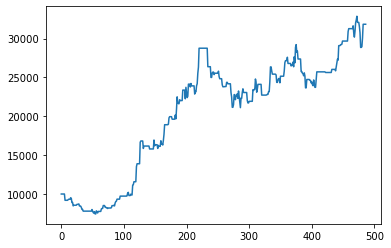

In [1194]:
'''查看一轮训练后，实现最高wealth的agent'''
best_memory['wealth'].plot()
print(milestone)

In [20]:
# best_model.save_weights(filepath='/Users/jingyugao/Desktop/学习/量化/rl')
# best_memory.to_csv('best_model_record.csv')

In [181]:
trader1.memory

,datetag,money,position,wealth,action,log_return,reward
0,2019-07-29 00:00:00,6.28,134.0,10000.0,"((tf.Tensor(1, shape=(), dtype=int64)))",NaN,96.394701
1,2019-07-30 00:00:00,6.28,134.0,10069.68,"((tf.Tensor(1, shape=(), dtype=int64)))",69.68,29.683002
2,2019-07-31 00:00:00,6.28,134.0,10360.46,"((tf.Tensor(1, shape=(), dtype=int64)))",290.78,-290.107776
3,2019-08-01 00:00:00,10699.48,0.0,10699.48,"((tf.Tensor(0, shape=(), dtype=int64)))",339.02,-699.030862
4,2019-08-02 00:00:00,47.99,127.0,10699.48,"((tf.Tensor(1, shape=(), dtype=int64)))",0.00,-776.700958
...,...,...,...,...,...,...,...
482,2021-07-22 00:00:00,8441.13,0.0,8441.13,"((tf.Tensor(2, shape=(), dtype=int64)))",0.00,206.6787
483,2021-07-23 00:00:00,36.17,131.0,8441.13,"((tf.Tensor(1, shape=(), dtype=int64)))",0.00,229.643
484,2021-07-26 00:00:00,36.17,131.0,8827.58,"((tf.Tensor(2, shape=(), dtype=int64)))",386.45,-174.23
485,2021-07-27 00:00:00,8653.35,0.0,8653.35,"((tf.Tensor(0, shape=(), dtype=int64)))",-174.23,0.0


## 训练结果  
1.简单的基于策略的深度学习模型训练效果不好，训练loss波动性太高不收敛。   
2.股票市场环境本身有较强的随机性，训练的reward和loss的计算完全依赖当前的一个轨迹，而每条轨迹只是门特卡洛抽样的一个样本。这条样本轨迹又依赖于每个时点agent采取的经过随机采样的行动。所以每次权重更新的信息很大程度上受随机性的影响。所以训练无法收敛。  
3.Actor-Critic中actor的行动虽然也来源于随机抽样，但critic部分，critic value的预测综合了之前全部轨迹样本的信息。可以利用actor- critic方法构建模型。

# 简单均线策略

利用最简单的均线策略，看所选标的在均线策略下能否提供收益。也许可以给强化学习的训练提供一些参考

In [1208]:
'''类base_trader可以继承agent，然后只重载决定行动的take_action方法。这里完整重写了base_trader类'''
class base_trader():
    '''
    state: dict(money,position,wealth)
    '''
    def __init__(self,initial_capital,stock_list):
        self.initial_capital=initial_capital
        self.state=dict(money=initial_capital,position=0,wealth=initial_capital)
        self.stock_list=stock_list
        self.action=[]
        self.memory=pd.DataFrame(columns=['datetag','money','position','wealth','action','log_return','reward'])
        self.action_sequence=[]

    def rl_model(self):
        return self.model
    
    def init_state(self):
        self.state=dict(money=self.initial_capital,position=0,wealth=self.initial_capital)

    def take_action(self,observation,t_small,t_large):
        '''
        action [0]: sell
        action [1]: buy
        action [2]: hold
        :param observation:
        :return:
        '''
        meanA=np.mean(observation[0][-t_small::])
        meanB=np.mean(observation[0][-t_large::])
        # print('ob3',observation[0][-t_small::],' ob5',observation[0][-t_large::])
        # print('meanA:',meanA,' meanB:',meanB)
        if meanA>meanB:
            self.action=[1]
        elif meanA<meanB:
            self.action=[0]
        else:
            self.action=[2]
        # self.action = action.numpy().flatten()
        self.action_sequence.append(self.action)
        return self.action

    def update_state(self,d_state):
        self.state['money'] += d_state['money']
        self.state['position'] += d_state['position']
        self.state['wealth'] = d_state['wealth']
        self.state['action'] = d_state['action']

    def update_memory(self,datetag):
        self.memory=self.memory.append(dict(datetag=datetag,money=self.state['money'],position=self.state['position'],
                                wealth=self.state['wealth'],action=self.state['action'],log_return=0,reward=0),ignore_index=True)

    def clear_memory(self):
        self.memory=self.memory.drop(index=self.memory.index)
        self.action_sequence=[]

    def calculate_reward(self,gamma=0.9):
        self.memory['log_return']=np.log(self.memory['wealth'].astype(float)) - np.log(self.memory['wealth'].astype(float)).shift(1)
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            R = R * gamma + t
            discounted_rewards[-i - 1] = R
        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        self.action=self.memory['action']
        

In [1215]:
'''对均线策略中的两条均线进行网格搜索，搜索出收益最好的两条均线，搜索范围可以自由确定，这里定位最长为11日均线'''
stock_code='688008'
max_record=0
for T in range(1,11):
# for T in [6]:
    for p in range(1,T):
    # for p in [4]:
        x_2=np.array([train_data[stock_code][i-T:i] for i in range(T,len(train_data[stock_code]))])
        trader_base=base_trader(initial_capital=10000,stock_list=[stock_code])
        mrk1=market_env(train_data,stock_code)
        for i,j in zip(range(len(mrk1.data.index[T-1:-2])),mrk1.data.index[T-1:-2]):
            observation=np.expand_dims(x_2[i],axis=0)
            action=trader_base.take_action(observation,p,T) 
            d_state=mrk1.reveive_action(trader_base.action,trader_base.state,j)
             # print(d_state)
            trader_base.update_state(d_state)
            trader_base.update_memory(j)
            
            if trader_base.state['wealth']>max_record:
                best_one=trader_base
                max_record=trader_base.state['wealth']
        print('large_gap:',T,'small_gap:',p,'state:',trader_base.state['wealth'],'std',np.std(trader_base.memory['wealth']))
# print(trader_base.memory)

large_gap: 2 small_gap: 1 state: 9199.650000000005 std 877.446973075395
large_gap: 3 small_gap: 1 state: 4986.630000000006 std 1552.1317886919849
large_gap: 3 small_gap: 2 state: 5906.770000000009 std 1244.8585211368138
large_gap: 4 small_gap: 1 state: 5653.200000000006 std 1349.6228263767591
large_gap: 4 small_gap: 2 state: 6862.029999999997 std 1011.5908607728435
large_gap: 4 small_gap: 3 state: 10292.439999999995 std 1776.5911967951163
large_gap: 5 small_gap: 1 state: 6871.260000000001 std 1401.930758742982
large_gap: 5 small_gap: 2 state: 9449.61999999999 std 776.223293010496
large_gap: 5 small_gap: 3 state: 10428.449999999999 std 1073.1706416116665
large_gap: 5 small_gap: 4 state: 14907.909999999996 std 2483.436220837451
large_gap: 6 small_gap: 1 state: 7832.599999999994 std 931.7840614838618
large_gap: 6 small_gap: 2 state: 9277.27 std 696.5633031531916
large_gap: 6 small_gap: 3 state: 10245.579999999996 std 911.9480752836397
large_gap: 6 small_gap: 4 state: 13387.5 std 1847.7786

网格搜索结果  
收益最好的为使用6日均线和4日均线进行交易，训练期间从账户余额从10000增长到13387.5。 
--large_gap: 6 small_gap: 4 state: 13387.5 std 1847.778642672263

{'money': 49.909999999998035, 'position': 230.0, 'wealth': 14907.909999999996, 'action': [1]}


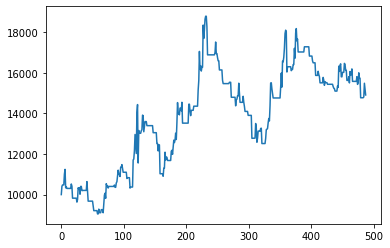

In [1216]:
plt.plot(best_one.memory['wealth'])
print(best_one.state)

# 模型输入数据的分布情况
## 检查输入对数收益率的分布情况

(array([  2.,   0.,   3.,  18.,  92., 258., 101.,  15.,   3.,   2.]),
 array([-0.2230918 , -0.18255047, -0.14200913, -0.1014678 , -0.06092646,
        -0.02038512,  0.02015621,  0.06069755,  0.10123888,  0.14178022,
         0.18232156]),
 <BarContainer object of 10 artists>)

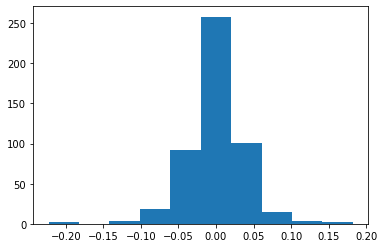

In [1416]:
plt.hist(log_return)

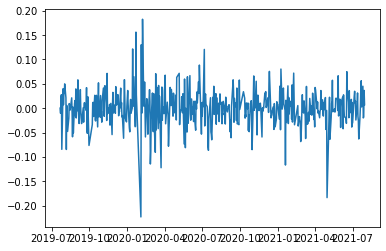

In [1418]:
plt.plot(log_return)

## 检查价格的分布情况

(array([18., 58., 88., 84., 75., 89., 38., 20., 12., 12.]),
 array([ 50.39 ,  57.107,  63.824,  70.541,  77.258,  83.975,  90.692,
         97.409, 104.126, 110.843, 117.56 ]),
 <BarContainer object of 10 artists>)

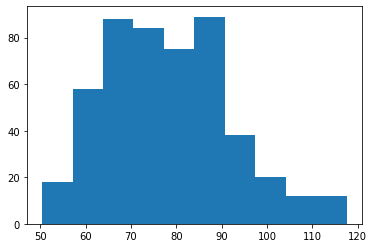

In [1419]:
plt.hist(one_stock_data)

# Actor-Critic方法和引入Critic的门特卡洛方法

由于policy learning效果不好，训练结果中loss波动性太高，利用actor- critic方法进行训练，降低波动性。  
**actor- critic**可以采用时间差分算法，计算时利用当前实际得到奖励和折现对未来奖励的估计（TD target）的来代表当前状态的reward。理论上算法可以在agent每执行一步行动后就进行一次训练和权值更新，与之相比普通的蒙特卡洛方法需要agent完成一整套流程得到轨迹后才能进行训练。
这里仍然采用蒙特卡洛方法，在得到agent的轨迹后进行训练。训练时直接利用agent每一步实际得到的reward作为TD target进行训练。同时将critic value作为baseline来计算advantage。

## actor-critic模型

模型共用一部分网络结构，共用部分之后分别经过actor部分计算policy，输出三个动作的logits，经过critic部分输出用来学习当前状态reward的critic value。

In [1094]:
'''actor-critic model'''
class ACmodel(tf.keras.Model):
    def __init__(self,units_num,action_nums,T):
        super().__init__()
        self.common_layer=tf.keras.layers.Dense(units_num,activation='leaky_relu',input_shape=(T,))
        # self.common_layer2=tf.keras.layers.Dense(18,activation='leaky_relu')
        self.action_layer=tf.keras.layers.Dense(action_nums)
        self.critic_layer=tf.keras.layers.Dense(1)
    def __call__(self,x):
        mid_x=self.common_layer(x)
        # mid_x=self.common_layer2(mid_x)
        return self.action_layer(mid_x),self.critic_layer(mid_x)

这里的agent类为ACagent，直接继承上面写好的agent类，对差别部分进行重写。

In [1095]:
class ACagent(agent):
    def __init__(self,initial_capital,stock_list):
        self.initial_capital=initial_capital
        self.state=dict(money=initial_capital,position=0,wealth=initial_capital)
        self.action=[]
        self.memory=pd.DataFrame(columns=['datetag','money','position','wealth','action','log_return','reward'])
        self.action_sequence=[]
        self.logits=[]
        self.critic_values=[]
        self.action_probs=[]
    
    def take_action(self,logits,value):
        '''
        action [0]: sell
        action [1]: buy
        action [2]: hold
        :param observation:
        :return:
        '''
        # logits,value = self.model(observation)
        probs= tf.nn.softmax(logits)
        self.action = tf.random.categorical(probs, num_samples=1)
  
        return self.action
    def clear_memory(self):
        super().clear_memory()
        self.logits=[]
        self.critic_values=[]
        self.action_probs=[]
        
    def deterministic_action(self,logits,value):
        probs= tf.nn.softmax(logits)
        self.action = tf.math.top_k(probs,k=1).indices.numpy()
        return self.action

相应的loss也由actor loss和critic loss两部分构成，可以引入超参决定两部分的占比，这里直接1:1相加。计算critic loss直接用mse即可，这里利用huber loss来减轻极值对mse的影响。

In [1147]:
'''compute loss'''
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
def compute_ACloss(action_probs, critic_values, returns): 
    advantage = returns- critic_values
    # print('advantage',tf.reduce_sum(advantage))

    action_log_probs = tf.math.log(action_probs)
    # print('action_log_probs',action_log_probs)
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)
    # print('actor_loss',actor_loss)

    critic_loss = huber_loss(critic_values, returns)
    # print('critic_loss',critic_loss)
    return  actor_loss+critic_loss           


将一轮实验写成run_episode，进行一次门特卡洛抽样，得到一次轨迹。

In [1153]:
def run_episode(acmodel,trader2,mrk1,record,milestone):
    trader2.init_state()
    trader2.clear_memory()
    obs_set=np.empty((0,T+2),float)
    
    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    critic_values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    
    '''根据当前模型预测交易行为0卖，1买，2不变'''
    for i,j in zip(range(len(mrk1.data.index[T-1:-2])),mrk1.data.index[T-1:-2]):
        '''这里的observation只有前T日的价格，但模型不收敛，考虑加特征维度:将T日平均，和T/2日平均加入输入'''
        observation=np.append(x[i],[np.mean(x[i]),np.mean(x[i][-round(T/2)::])])
        observation=tf.expand_dims(observation,axis=0)
        obs_set=np.vstack((obs_set,observation))
    
        '''将observation输入模型'''
        logits,value=acmodel(observation)
        probs= tf.nn.softmax(logits)
        critic_values=critic_values.write(i,tf.squeeze(value))
        '''take action 里的步骤'''
        action=trader2.take_action(logits,value)
        try:
            act_prob=probs[0,action[0,0]]
        except:
            print('failure:',action)
        
        action_probs=action_probs.write(i,act_prob)
        
        d_state=mrk1.reveive_action(action,trader2.state,j)
        # print(d_state)
        trader2.update_state(d_state)
        
        '''update_memory'''
        trader2.update_memory(j)
        
    record.append(trader2.state['wealth'])
    
    '''计算reward：gamma=0.9 效果不好 '''
    trader2.calculate_second_reward(gamma=0.9)
    
    '''记录最佳模型'''
    if trader2.state['wealth']>milestone:
        best_model=acmodel
        best_memory=trader2.memory
        milestone=trader2.state['wealth']
    
    
    reward_sdz=(trader2.memory['reward']-np.mean(trader2.memory['reward']))/(np.std(trader2.memory['reward'])+0.00001)
    reward_sdz=tf.convert_to_tensor(reward_sdz.fillna(0).astype('float32'))

    '''模型参数更新'''
    
    
    action_probs=action_probs.stack()
    critic_values=critic_values.stack()

    # action_probs=tf.expand_dims(action_probs,axis=1)
    # critic_values=tf.expand_dims(critic_values,axis=1)
    # reward_sdz=tf.expand_dims(rewards,axis=1)

    return action_probs,critic_values,reward_sdz


初始化各个组件，准备训练数据

In [1219]:
'''test train code'''
T=6
stock='688008'
one_stock_data=train_data[stock]

'''尝试将x转化为log收益率，将收益率作为模型输入'''
# log_return=np.log(one_stock_data) - np.log(one_stock_data).shift(1)
# log_return=log_return.fillna(0)
# log_return=log_return*10
# x=np.array([log_return[i-T:i] for i in range(T,len(log_return))])   

'''直接利用价格作为模型输入'''
x=np.array([one_stock_data[i-T:i] for i in range(T,len(one_stock_data))])
'''尝试将x标准化'''
x=(x-np.mean(x))/np.std(x)

x_mean=np.mean(x)
x_std=np.std(x)

acmodel = ACmodel(128,3,T+2)
trader2=ACagent(initial_capital=10000,stock_list=[stock])
mrk1=market_env(train_data,stock)

进行actor- critic模型的训练。其中将**agent所采取行动的对数概率**的均值作为agent采取行动的置信水平，也就是agent对当前行动的把握程度。当置信水平和收益满足条件后，完成模型的训练。   
这里选用0.52作为置信水平阈值，当置信水平大于0.52日说明当前agent所采取行动的概率超过60%。（60% * 60% + 40% * 40%）=0.52

In [1221]:
'''actor-critic训练过程，并记录训练过程中出现的最佳模型'''
episode=100
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
record=[]
loss_sequence=[]
milestone=0

former_layer_weight=acmodel.get_weights()

for k in range(episode):
    '''初始化模型state 和 起始资金'''

    with tf.GradientTape() as tape: 
        # tape.watch(trader2.model.trainable_variables)
        action_probs,critic_values,rewards=run_episode(acmodel,trader2,mrk1,record,milestone)
        
        action_probs=tf.expand_dims(action_probs,axis=1)
        critic_values=tf.expand_dims(critic_values,axis=1)
        rewards=tf.expand_dims(rewards,axis=1)

        loss=compute_ACloss(action_probs,critic_values,rewards)

    loss_sequence.append(loss)
    grads=tape.gradient(loss,acmodel.trainable_variables)
    optimizer.apply_gradients(zip(grads, acmodel.trainable_variables))
    confidence=np.mean(action_probs)

    print('epoch----------',k,'loss:',np.mean(loss),' wealth:',trader2.state['wealth'],'confidence:',confidence)
    
    if confidence>0.52 and trader2.state['wealth']>20000 :
        break

    
    '''查看权值更新情况'''
    # first_layer_weight=trader2.model.get_weights()
    # weights_diff=np.array(first_layer_weight)-np.array(former_layer_weight)
    # former_layer_weight=first_layer_weight
    # print('weights_diff: ',weights_diff)


epoch---------- 0 loss: 87.48722  wealth: 3102.3200000000015 confidence: 0.34355572
epoch---------- 1 loss: 58.293777  wealth: 8524.120000000012 confidence: 0.34541726
epoch---------- 2 loss: 52.141098  wealth: 8909.299999999992 confidence: 0.34122914
epoch---------- 3 loss: 23.449951  wealth: 6442.769999999998 confidence: 0.34203056
epoch---------- 4 loss: 23.948135  wealth: 21917.73999999999 confidence: 0.34798324
epoch---------- 5 loss: -27.602646  wealth: 5254.399999999988 confidence: 0.33879992
epoch---------- 6 loss: -63.700424  wealth: 8376.42 confidence: 0.34508425
epoch---------- 7 loss: -53.643326  wealth: 5348.300000000006 confidence: 0.34423545
epoch---------- 8 loss: -75.68875  wealth: 10716.009999999987 confidence: 0.33777973
epoch---------- 9 loss: -79.0264  wealth: 9010.799999999983 confidence: 0.3500447
epoch---------- 10 loss: -40.93271  wealth: 7519.099999999997 confidence: 0.36218086
epoch---------- 11 loss: -76.67859  wealth: 7397.659999999997 confidence: 0.3681603

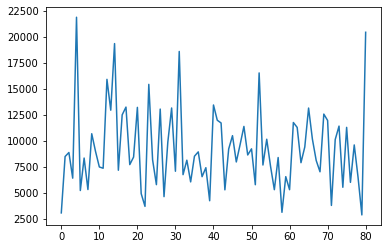

In [1223]:
plt.plot(record)

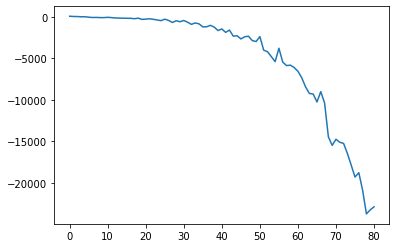

In [1222]:
plt.plot(loss_sequence)

可以看到，loss随训练逐渐减小。说明模型收敛，actor- critic解决了之前策略强化学习loss波动性过高的问题。

<AxesSubplot:>

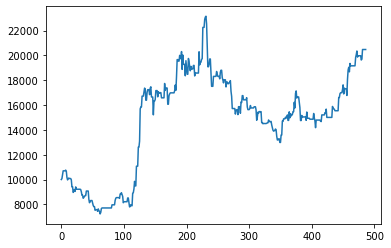

In [1224]:
trader2.memory['wealth'].plot()

0


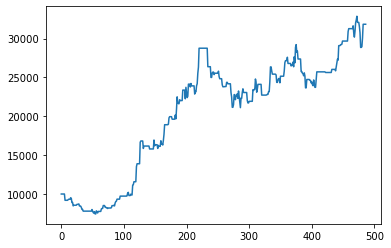

In [1225]:
'''查看一轮训练后，实现最高wealth的agent'''
best_memory['wealth'].plot()
print(milestone)

actor-loss 和critic-loss有trade-off的现象。由于reward计算方式的问题，有时候loss减小后，但模型最终的余额

## 测试模型的性能     
利用2021年8月1日到2022年4月15日数据测试训练后模型的性能。在测试阶段，为了避免随机抽样对模型结果的影响，可以考虑测试时利用deterministic_action方法确定行动，即利用DDGP算法的思路，输出唯一确定的policy。

In [1226]:
'''准备数据'''
test_data=data[data.index>'2021-07-31']

T=6
stock='688008'
one_stock_test=test_data[stock]

'''尝试将x转化为log收益率，将收益率作为模型输入'''
# log_return=np.log(one_stock_data) - np.log(one_stock_data).shift(1)
# log_return=log_return.fillna(0)
# log_return=log_return*10
# x=np.array([log_return[i-T:i] for i in range(T,len(log_return))])   

'''直接利用价格作为模型输入'''
x=np.array([one_stock_test[i-T:i] for i in range(T,len(one_stock_test))])
'''尝试将x标准化'''
x=(x-x_mean)/x_std
trader_test_performance=ACagent(initial_capital=10000,stock_list=[stock])
test_mrk=market_env(test_data,stock)

In [1227]:
def test_model_performance(x,test_mrk,trader2,acmodel):
    obs_set=np.empty((0,T+2),float)
    
    '''根据当前模型预测交易行为0卖，1买，2不变'''
    for i,j in zip(range(len(test_mrk.data.index[T-1:-2])),test_mrk.data.index[T-1:-2]):
        '''这里的observation只有前T日的价格，但模型不收敛，考虑加特征维度:将T日平均，和T/2日平均加入输入'''
        observation=np.append(x[i],[np.mean(x[i]),np.mean(x[i][-round(T/2)::])])
        observation=tf.expand_dims(observation,axis=0)
        obs_set=np.vstack((obs_set,observation))
    
        '''将observation输入模型'''
        logits,value=acmodel(observation)
        
        '''take action 里的步骤'''
        action=trader2.take_action(logits,value)
        d_state=test_mrk.reveive_action(action,trader2.state,j)
        # print(d_state)
        trader2.update_state(d_state)
        
        '''update_memory'''
        trader2.update_memory(j)
    

In [1228]:
test_model_performance(x,test_mrk,trader_test_performance,acmodel)


In [1229]:
trader_test_performance.memory

,datetag,money,position,wealth,action,log_return,reward
0,2021-08-09 00:00:00,58.63,163.0,10000.0,"((tf.Tensor(1, shape=(), dtype=int64)))",0,0
1,2021-08-10 00:00:00,58.63,163.0,10717.2,"((tf.Tensor(2, shape=(), dtype=int64)))",0,0
2,2021-08-11 00:00:00,58.63,163.0,10542.79,"((tf.Tensor(2, shape=(), dtype=int64)))",0,0
3,2021-08-12 00:00:00,58.63,163.0,10555.83,"((tf.Tensor(1, shape=(), dtype=int64)))",0,0
4,2021-08-13 00:00:00,58.63,163.0,9837.0,"((tf.Tensor(1, shape=(), dtype=int64)))",0,0
...,...,...,...,...,...,...,...
158,2022-04-07 00:00:00,15705.96,0.0,15705.96,"((tf.Tensor(2, shape=(), dtype=int64)))",0,0
159,2022-04-08 00:00:00,15705.96,0.0,15705.96,"((tf.Tensor(2, shape=(), dtype=int64)))",0,0
160,2022-04-11 00:00:00,15705.96,0.0,15705.96,"((tf.Tensor(0, shape=(), dtype=int64)))",0,0
161,2022-04-12 00:00:00,15705.96,0.0,15705.96,"((tf.Tensor(2, shape=(), dtype=int64)))",0,0


下图展示模型在测试数据集中的表现，余额从最初的10000，增长到最终的15705.96

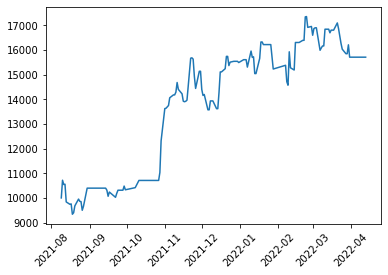

In [1230]:
plt.plot(trader_test_performance.memory['datetag'],trader_test_performance.memory['wealth'])
plt.xticks(rotation=45)
plt.show()


1. 无法避免的轨迹随机性。由于训练过程仍存在一定的随机性，重复训练后的模型表现可能存在差异。  
2. 2022年3月中到4月，由于宏观市场环境震荡，科创板市场行情出现较大下跌，此阶段的数据规律和数据模式可能在训练数据中很少见，所以大部分模型的测试结果都显示，模型在2022年3月前保持良好收益，但在3月到4月开始大幅下跌。